# Mise en place

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2 as cv

In [ ]:
## Execute this when running the notebook on google colab
from google.colab import drive
drive.mount('/content/drive')
# Then change this to your own folder path containing the notebook
folder_path = "/content/drive/MyDrive/TREC_Codage"

Mounted at /content/drive


In [2]:
folder_path = ""

# Préparation des données

## Séparation et redimensionnement des images

In [ ]:
# Pour charger le dataset de Hamza
import pickle
import numpy as np
file = f'{folder_path}/data_resultsheets/data.pkl'
with open(file, 'rb') as f:
      pict, label = pickle.load(f)
print(pict.shape)
print(label.shape)

(1719, 74, 74)
(1719,)


In [3]:
# Importation des dataset
file_name = [f"0{x}" for x in range(1, 10)]
full_da = np.loadtxt(f'{folder_path}data_resultsheets/{file_name[0]}.csv', dtype = "int32", delimiter=',')
for file in file_name[1:]:
    da = np.loadtxt(f'{folder_path}data_resultsheets/{file}.csv', dtype = "int32", delimiter=',')
    full_da = np.append(full_da, da, axis = 0)
file_name_b2 = [f"IMG_000{x}" for x in range(1, 10)]
for file in file_name_b2:
    da = np.loadtxt(f'{folder_path}data_resultsheets/{file}.csv', dtype = "int32", delimiter=',')
    full_da = np.append(full_da, da, axis = 0)
print(full_da.shape)
print(full_da)


(3403, 6233)
[[255 255 255 ... 255 255   1]
 [255 255 255 ... 255 255   1]
 [255 255 255 ... 255 255   1]
 ...
 [255 255 255 ... 255 255   9]
 [254 255 255 ... 255 255   9]
 [255 255 255 ... 255 255   9]]


In [4]:
# Separation of images and labels
full_da_split = np.split(full_da, [6232], axis = 1)
pict = full_da_split[0]
label = full_da_split[1]
print(pict.shape)
print(label.shape)
# Reshape pict data into matrices corresponding to image size used in extraction
pict = pict.reshape((len(pict), 76, 82))
print(pict.shape)

(3403, 6232)
(3403, 1)
3403
(3403, 76, 82)


In [5]:
# Redimension pictures
new_size = (28, 28)
pict = pict.astype(np.float32)
pict = pict.reshape(-1, pict.shape[1], pict.shape[2], 1)
pict_redim = np.empty((len(pict), 28, 28))
# Boucle sur chaque image de l'array
for i in range(len(pict)):
    img_resized = cv.resize(pict[i], new_size, interpolation=cv.INTER_AREA)
    pict_redim[i] = img_resized
print(pict_redim.shape)

(3403, 28, 28)


## Train-test split

Training DataArray :
(2268, 28, 28)
(2268, 1)
Test DataArray :
(1135, 28, 28)
(1135, 1)


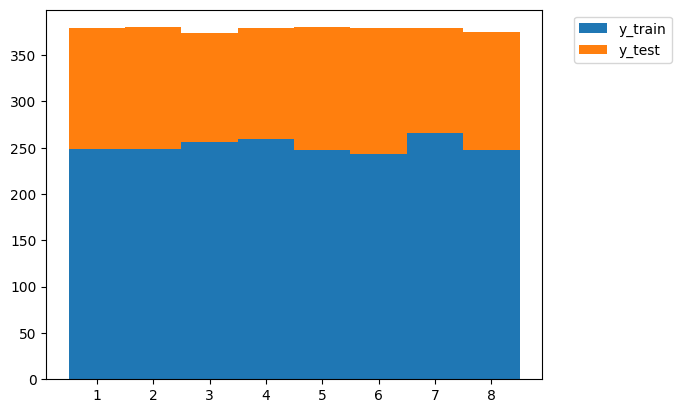

In [6]:
# Split the DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pict_redim, label, test_size=1/3, random_state=42)

# Display the first five rows of the training DataFrame
print("Training DataArray :")
print(X_train.shape)
print(y_train.shape)

# Display the first five rows of the test DataFrame
print("Test DataArray :")
print(X_test.shape)
print(y_test.shape)
plt.hist([y_train.flatten(), y_test.flatten()], bins=np.arange(0.5, 9.5, 1), stacked=True, label=['y_train', 'y_test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


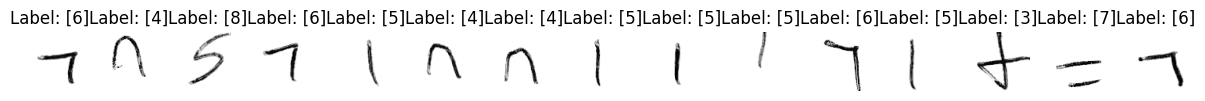

In [7]:
# Define a function to visualize samples from the dataset
def visualize_samples(X, y, num_samples=5):
    # Obtain a subset of random indices
    sample_indices = np.random.choice(len(X), num_samples, replace=False)

    # Create a grid plot for the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
    for i, idx in enumerate(sample_indices):
        # Reshape and display each sample as an image
        axes[i].imshow(X[idx], cmap='gray')
        # Set the title for each subplot as the corresponding label
        axes[i].set_title(f"Label: {y[idx]}")
        # Hide axis ticks for a cleaner look
        axes[i].axis('off')
    # Adjust layout for better spacing between subplots
    plt.tight_layout()
    # Display the plot
    plt.show()

# Call the function to visualize 10 random samples from the dataset
visualize_samples(pict, label, num_samples=15)



In [8]:
# Get the shape of the first training sample
print(X_train[0].shape)


(28, 28)


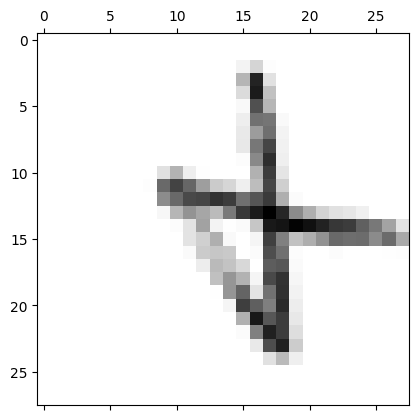

In [9]:
# Visualize the third training sample as an image
plt.matshow(X_train[2], cmap = "gray")
plt.show()  # Display the plot

## Normalisation et création des vecteurs d'image

In [10]:
# Normalize the pixel values of the images to be between 0 and 1
X_train = X_train / 255
X_test = X_test / 255


In [11]:
# Flatten the 28x28 images into a 784 element vector for each image
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)
# Check the shape of the flattened training set (should be [num_samples, 784])
print(X_train_flattened.shape)
print(X_test_flattened.shape)

(2268, 784)
(1135, 784)


# Entrainement du modèle

In [12]:
# Define the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train-1, epochs=128, batch_size=64)



Epoch 1/128
36/36 [==============================] - 1s 3ms/step - loss: 2.2023 - accuracy: 0.1332
Epoch 2/128
36/36 [==============================] - 0s 2ms/step - loss: 2.0153 - accuracy: 0.3038
Epoch 3/128
36/36 [==============================] - 0s 3ms/step - loss: 1.8464 - accuracy: 0.4065
Epoch 4/128
36/36 [==============================] - 0s 4ms/step - loss: 1.6462 - accuracy: 0.4766
Epoch 5/128
36/36 [==============================] - 0s 3ms/step - loss: 1.4613 - accuracy: 0.5745
Epoch 6/128
36/36 [==============================] - 0s 3ms/step - loss: 1.3199 - accuracy: 0.6261
Epoch 7/128
36/36 [==============================] - 0s 4ms/step - loss: 1.2188 - accuracy: 0.6327
Epoch 8/128
36/36 [==============================] - 0s 3ms/step - loss: 1.1025 - accuracy: 0.6852
Epoch 9/128
36/36 [==============================] - 0s 4ms/step - loss: 1.0021 - accuracy: 0.7368
Epoch 10/128
36/36 [==============================] - 0s 3ms/step - loss: 0.9552 - accuracy: 0.7381
Epoch 11/

36/36 [==============================] - 0s 3ms/step - loss: 0.1142 - accuracy: 0.9705
Epoch 84/128
36/36 [==============================] - 0s 3ms/step - loss: 0.0915 - accuracy: 0.9788
Epoch 85/128
36/36 [==============================] - 0s 3ms/step - loss: 0.0708 - accuracy: 0.9868
Epoch 86/128
36/36 [==============================] - 0s 2ms/step - loss: 0.0792 - accuracy: 0.9837
Epoch 87/128
36/36 [==============================] - 0s 2ms/step - loss: 0.0743 - accuracy: 0.9846
Epoch 88/128
36/36 [==============================] - 0s 3ms/step - loss: 0.0783 - accuracy: 0.9859
Epoch 89/128
36/36 [==============================] - 0s 3ms/step - loss: 0.0913 - accuracy: 0.9753
Epoch 90/128
36/36 [==============================] - 0s 2ms/step - loss: 0.0745 - accuracy: 0.9832
Epoch 91/128
36/36 [==============================] - 0s 3ms/step - loss: 0.0750 - accuracy: 0.9854
Epoch 92/128
36/36 [==============================] - 0s 3ms/step - loss: 0.0647 - accuracy: 0.9863
Epoch 93/128


# Evaluation du modèle

In [13]:
# Evaluate the model on the test set
# Subtracting 1 from y_test to align labels if they originally start from 1
test_loss, test_accuracy = model.evaluate(X_test, y_test - 1)
# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

36/36 [==============================] - 0s 2ms/step - loss: 0.3406 - accuracy: 0.9313
Test Loss: 0.34064850211143494
Test Accuracy: 0.9312775135040283


In [14]:
# Generate predictions for the test set
y_predicted = model.predict(X_test)
# Use np.argmax to find the index of the maximum value in the first set of predictions,
# which corresponds to the model's predicted class label for the first image
# Pour détecter les erreur: ajouter une conditions : si
predicted_label = np.argmax(y_predicted[0])
# Convert the model's predictions from probability distributions to class labels
# by finding the index of the max probability for each prediction and adding 1
y_predicted_labels = [np.argmax(i) + 1 for i in y_predicted]

36/36 [==============================] - 0s 2ms/step


Text(95.72222222222221, 0.5, 'Truth')

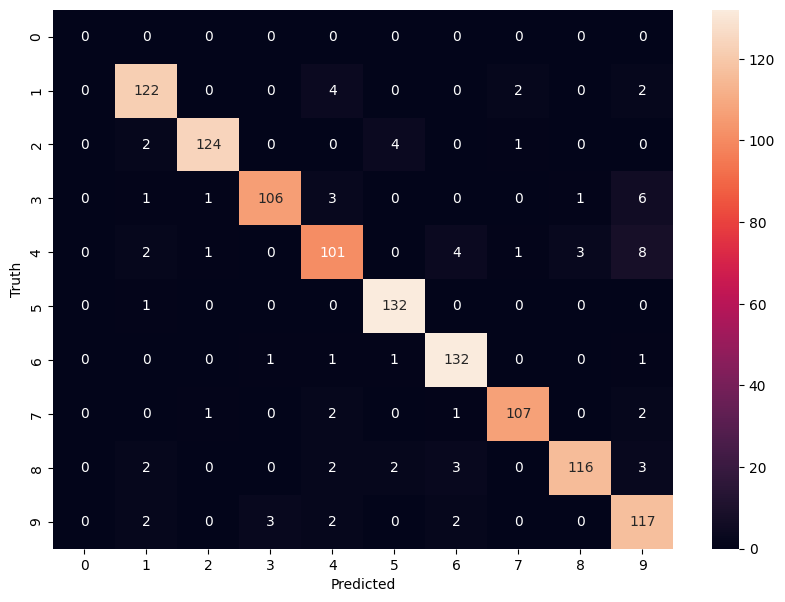

In [15]:
# Generate a confusion matrix to compare the true labels (y_test)
# against the model's predicted labels (y_predicted_labels)
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)
# Set the size of the figure for the heatmap
plt.figure(figsize=(10, 7))

# Create a heatmap to visualize the confusion matrix
# 'annot=True' annotates each cell with the integer value (formatted as 'd' for decimal)
# 'fmt='d'' specifies numeric formatting for annotations
sns.heatmap(cm, annot=True, fmt='d')

# Label the x-axis as "Predicted"
plt.xlabel("Predicted")

# Label the y-axis as "Truth"
plt.ylabel("Truth")

# Save the model

In [16]:
# Save the model to the specified path
model.save("model_CS_20240416")

# Evaluate the model on the test dataset to get the loss value & metrics values for the model
test_loss, test_accuracy = model.evaluate(X_test, y_test -1)

# Print out the model's performance on the test dataset
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


INFO:tensorflow:Assets written to: model_CS_20240416\assets


INFO:tensorflow:Assets written to: model_CS_20240416\assets


36/36 [==============================] - 0s 2ms/step - loss: 0.3406 - accuracy: 0.9313
Test Loss: 0.34064850211143494, Test Accuracy: 0.9312775135040283
